# Compare Different MCMC Methods

The following output path will serve as folder for Julia results. As emphasized in the paper, the computation in the main results are done in Julia but visualized in R. The MAIN RESULTS folder below will accomodate the Julia output which will be imported to R for visualization.

In [1]:
out_path = joinpath(homedir(), "Dropbox/MS THESIS/R/MAIN RESULTS");

In [2]:
using Distributions: pdf, rand, Uniform, Normal
using DataFrames: DataFrame, nrow, writetable, stack, unstack
using Gadfly
using RDatasets
Gadfly.push_theme(:dark)

## 1 Functions
The following imports the MCMC functions needed for later computations.

In [3]:
include(joinpath(homedir(), "Dropbox/MS THESIS/JULIA/MH.jl"));
include(joinpath(homedir(), "Dropbox/MS THESIS/JULIA/HMC.jl"));
include(joinpath(homedir(), "Dropbox/MS THESIS/JULIA/SG HMC.jl"));

## 2 Bayesian Linear Regression

In [4]:
# The log likelihood function is given by the following codes:
function loglike(theta::Array{Float64}; alpha::Float64 = alpha, x::Array{Float64} = x, y::Array{Float64} = y)
  yhat = theta[1] + theta[2] * x

  likhood = Float64[]
  for i in 1:length(yhat)
    push!(likhood, pdf(Normal(yhat[i], alpha), y[i]))
  end

  return likhood |> sum
end

# Define the log prior and lo posterior
function logprior(theta::Array{Float64}; mu::Array{Float64} = mu, s::Array{Float64} = s)
  w0_prior = log(pdf(Normal(mu[1, 1], s[1, 1]), theta[1]))
  w1_prior = log(pdf(Normal(mu[2, 1], s[2, 2]), theta[2]))
   w_prior = [w0_prior w1_prior]

  return w_prior |> sum
end

function logpost(theta::Array{Float64})
  loglike(theta, alpha = alpha, x = x, y = y) + logprior(theta, mu = mu, s = s)
end

Potential(theta::Array{Float64}) = - logpost(theta)
Kinetic(p::Array{Float64}; Σ = eye(length(p))) = (p' * inv(Σ) * p) / 2
function dPotential(theta::Array{Float64}; alpha::Float64 = 1/5., b::Float64 = 2.)
  [-alpha * sum(y - (theta[1] + theta[2] * x));
   -alpha * sum((y - (theta[1] + theta[2] * x)) .* x)] + b * theta
end
function dPotential_noise(theta::Array{Float64}; alpha::Float64 = 1/5., b::Float64 = 2.)
  [-alpha * sum(y - (theta[1] + theta[2] * x));
   -alpha * sum((y - (theta[1] + theta[2] * x)) .* x)] + b * theta + randn(2, 1)
end
dKinetic(p::AbstractArray{Float64}; Σ::Array{Float64} = eye(length(p))) = inv(Σ) * p;

In [136]:
srand(111);
w0 = -.3; w1 = -.5; stdev = 5.;

# Define data parameters
alpha = 1 / stdev; # for likelihood

# Generate Hypothetical Data
n = 1000;
x = rand(Uniform(-1, 1), n);
A = [ones(length(x)) x];
B = [w0; w1];
f = A * B;
y = f + rand(Normal(0, alpha), n);

# Define Hyperparameters
Imat = eye(2);
b = 2.; # for prior
b1 = (1 / b)^2; # Square this since in Julia, rnorm uses standard dev

mu = zeros(2); # for prior
s = b1 * Imat; # for prior

xy_df = DataFrame(X = x, Y = y);

Export the simulated x and y:

In [137]:
writetable(joinpath(out_path, "Simulated X and Y.csv"), DataFrame(X = x, Y = y))

### 2.1 Metropolis-Hasting

In [138]:
mh_object = MH(logpost);
@time chain1 = mcmc(mh_object, r = 10000);

  1.208835 seconds (677.93 k allocations: 647.640 MB, 13.24% gc time)


In [139]:
mapslices(mean, chain1[Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000)), :], [1])

1×2 Array{Float64,2}:
 -0.318779  -0.487093

In [140]:
xy_df_mh = xy_df;

In [141]:
xy_df_mh[:Yhat] = mapslices(mean, chain1[Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000)), :], [1])[1] + mapslices(mean, chain1[Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000)), :], [1])[2] * xy_df[:X];

In [142]:
burn_in = 1000
for i in Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000))
    xy_df_mh[Symbol("Yhat_Sample_" * string(i))] = chain1[i, 1] + chain1[i, 2] * xy_df_mh[:X]
end

In [143]:
xy_stack_mh = DataFrame(X = repeat(Array(xy_df_mh[:X]), outer = 3000), 
                        Y = repeat(Array(xy_df_mh[:Y]), outer = 3000),
                        Var = Array(stack(xy_df_mh[:, 4:end])[1]),
                        Val = Array(stack(xy_df_mh[:, 4:end])[2]));

In [144]:
ch1cor_df = DataFrame(x = collect(0:1:(length(autocor(chain1[Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000)), 1])) - 1)), 
                      y1 = autocor(chain1[Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000)), 1]),
                      y2 = autocor(chain1[Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000)), 2]));

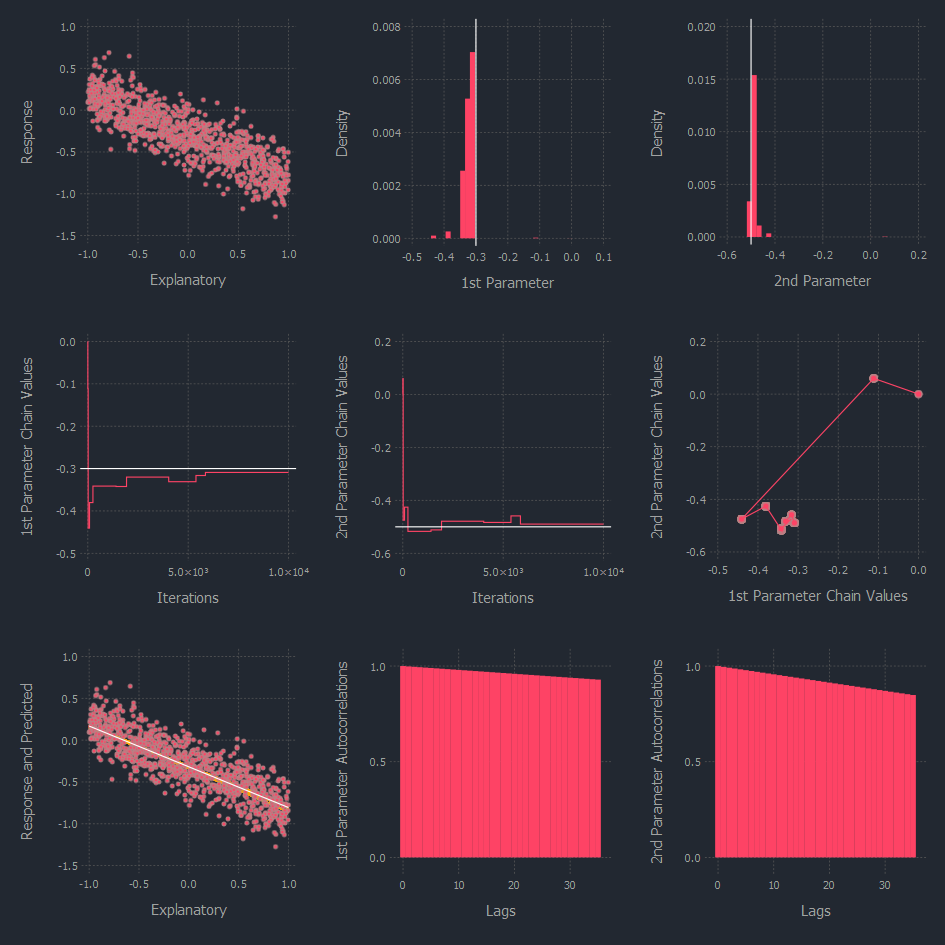

In [145]:
p0 = plot(xy_df, x = :X, y = :Y, Geom.point, style(default_point_size = .05cm), Guide.xlabel("Explanatory"), Guide.ylabel("Response"))
p1 = plot(DataFrame(chain1), x = :x1, xintercept = [-.3], Geom.vline(color = colorant"white"), Geom.histogram(bincount = 30, density = true), Guide.xlabel("1st Parameter"), Guide.ylabel("Density"))
p2 = plot(DataFrame(chain1), x = :x2, xintercept = [-.5], Geom.vline(color = colorant"white"), Geom.histogram(bincount = 30, density = true), Guide.xlabel("2nd Parameter"), Guide.ylabel("Density"))
p3 = plot(DataFrame(chain1), x = collect(1:nrow(DataFrame(chain1))), y = :x1, yintercept = [-.3], Geom.hline(color = colorant"white"), Geom.line, Guide.xlabel("Iterations"), Guide.ylabel("1st Parameter Chain Values"))
p4 = plot(DataFrame(chain1), x = collect(1:nrow(DataFrame(chain1))), y = :x2, yintercept = [-.5], Geom.hline(color = colorant"white"), Geom.line, Guide.xlabel("Iterations"), Guide.ylabel("2nd Parameter Chain Values"))
p5 = plot(DataFrame(chain1), x = :x1, y = :x2, Geom.path, Geom.point, Guide.xlabel("1st Parameter Chain Values"), Guide.ylabel("2nd Parameter Chain Values"))
p6 = plot(layer(xy_df_mh, x = :X, y = :Yhat, Geom.line, style(default_color = colorant"white")),
          layer(xy_df_mh, x = :X, y = :Y, Geom.point, style(default_point_size = .05cm)),
          layer(xy_stack_mh, x = :X, y = :Val, group = :Var, Geom.line, style(default_color = colorant"orange")),
          Guide.xlabel("Explanatory"), Guide.ylabel("Response and Predicted"))
p7 = plot(ch1cor_df, x = :x, y = :y1, Geom.bar, Guide.xlabel("Lags"), Guide.ylabel("1st Parameter Autocorrelations"), Coord.cartesian(xmin = -1, xmax = 36, ymin = -.05, ymax = 1.05))
p8 = plot(ch1cor_df, x = :x, y = :y2, Geom.bar,  Guide.xlabel("Lags"), Guide.ylabel("2nd Parameter Autocorrelations"), Coord.cartesian(xmin = -1, xmax = 36, ymin = -.05, ymax = 1.05))
draw(PNG(25cm, 25cm), vstack(hstack(p0, p1, p2), hstack(p3, p4, p5), hstack(p6, p7, p8)))

Export the above output for R visualization.

In [146]:
writetable(joinpath(out_path, "MH Simulations.csv"), chain1 |> DataFrame)

### 2.2 Gibbs

### 2.3 Hamiltonian Monte Carlo

In [147]:
hmc_object = HMC(Potential, Kinetic, dPotential, dKinetic, zeros(2, 1), 2);
@time chain3 = mcmc(hmc_object, r = 10000);

 19.146480 seconds (18.96 M allocations: 22.445 GB, 13.58% gc time)


In [148]:
mapslices(mean, chain3, [1])

1×2 Array{Float64,2}:
 -0.313293  -0.499871

In [149]:
xy_df_hmc = xy_df;

In [150]:
xy_df_hmc[:Yhat] = mapslices(mean, chain3, [1])[1] + mapslices(mean, chain3, [1])[2] * xy_df_hmc[:X];

In [151]:
burn_in = 1000
for i in Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000))
    xy_df_hmc[Symbol("Yhat_Sample_" * string(i))] = chain3[i, 1] + chain3[i, 2] * xy_df_hmc[:X]
end

In [152]:
xy_stack_hmc = DataFrame(X = repeat(Array(xy_df_hmc[:X]), outer = 3000), 
                         Y = repeat(Array(xy_df_hmc[:Y]), outer = 3000),
                         Var = Array(stack(xy_df_hmc[:, 4:end])[1]),
                         Val = Array(stack(xy_df_hmc[:, 4:end])[2]));

In [153]:
ch3cor_df = DataFrame(x = collect(0:1:(length(autocor(chain3[:, 1])) - 1)), 
                      y1 = autocor(chain3[:, 1]),
                      y2 = autocor(chain3[:, 2]));

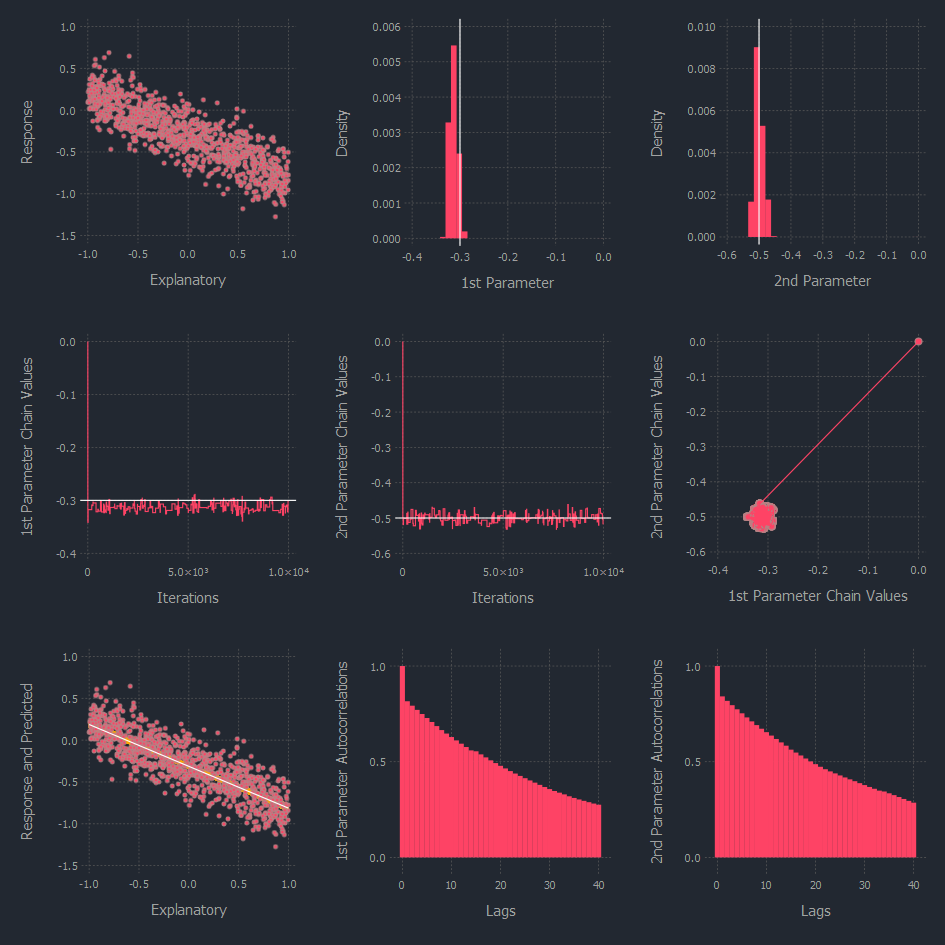

In [154]:
p0 = plot(xy_df, x = :X, y = :Y, Geom.point, style(default_point_size = .05cm), Guide.xlabel("Explanatory"), Guide.ylabel("Response"))
p1 = plot(DataFrame(chain3), x = :x1, xintercept = [-.3], Geom.vline(color = colorant"white"), Geom.histogram(bincount = 30, density = true), Guide.xlabel("1st Parameter"), Guide.ylabel("Density"))
p2 = plot(DataFrame(chain3), x = :x2, xintercept = [-.5], Geom.vline(color = colorant"white"), Geom.histogram(bincount = 30, density = true), Guide.xlabel("2nd Parameter"), Guide.ylabel("Density"))
p3 = plot(DataFrame(chain3), x = collect(1:nrow(DataFrame(chain3))), y = :x1, yintercept = [-.3], Geom.hline(color = colorant"white"), Geom.line, Guide.xlabel("Iterations"), Guide.ylabel("1st Parameter Chain Values"))
p4 = plot(DataFrame(chain3), x = collect(1:nrow(DataFrame(chain3))), y = :x2, yintercept = [-.5], Geom.hline(color = colorant"white"), Geom.line, Guide.xlabel("Iterations"), Guide.ylabel("2nd Parameter Chain Values"))
p5 = plot(DataFrame(chain3), x = :x1, y = :x2, Geom.path, Geom.point, Guide.xlabel("1st Parameter Chain Values"), Guide.ylabel("2nd Parameter Chain Values"))
p6 = plot(layer(xy_df_hmc, x = :X, y = :Yhat, Geom.line, style(default_color = colorant"white")),
          layer(xy_df_hmc, x = :X, y = :Y, Geom.point, style(default_point_size = .05cm)),
          layer(xy_stack_hmc, x = :X, y = :Val, group = :Var, Geom.line, style(default_color = colorant"orange")),
          Guide.xlabel("Explanatory"), Guide.ylabel("Response and Predicted"))
p7 = plot(ch3cor_df, x = :x, y = :y1, Geom.bar, Guide.xlabel("Lags"), Guide.ylabel("1st Parameter Autocorrelations"), Coord.cartesian(xmin = -1, xmax = 41, ymin = -.05, ymax = 1.05))
p8 = plot(ch3cor_df, x = :x, y = :y2, Geom.bar,  Guide.xlabel("Lags"), Guide.ylabel("2nd Parameter Autocorrelations"), Coord.cartesian(xmin = -1, xmax = 41, ymin = -.05, ymax = 1.05))
draw(PNG(25cm, 25cm), vstack(hstack(p0, p1, p2), hstack(p3, p4, p5), hstack(p6, p7, p8)))

Export the above output for R visualization.

In [155]:
writetable(joinpath(out_path, "HMC Simulations.csv"), chain3 |> DataFrame)

### 2.4 Stochastic Gradient Hamiltonian Monte Carlo

In [156]:
SGHMC_object = SGHMC(dPotential_noise, dKinetic, eye(2), eye(2), eye(2), [0; 0], 2.);
@time chain4 = mcmc(SGHMC_object, r = 10000)#, leapfrog_params = Dict([:ɛ => .009, :τ => 20]));

 15.333037 seconds (20.49 M allocations: 11.414 GB, 10.01% gc time)


In [157]:
mapslices(mean, chain4, [1])

1×2 Array{Float64,2}:
 -0.307161  -0.494349

In [158]:
xy_df_sghmc = xy_df;

In [159]:
xy_df_sghmc[:Yhat] = mapslices(mean, chain3, [1])[1] + mapslices(mean, chain3, [1])[2] * xy_df_sghmc[:X];

In [160]:
burn_in = 1000
for i in Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000))
    xy_df_sghmc[Symbol("Yhat_Sample_" * string(i))] = chain4[i, 1] + chain4[i, 2] * xy_df_sghmc[:X]
end

In [161]:
xy_stack_sghmc = DataFrame(X = repeat(Array(xy_df_sghmc[:X]), outer = 3000), 
                           Y = repeat(Array(xy_df_sghmc[:Y]), outer = 3000),
                           Var = Array(stack(xy_df_sghmc[:, 4:end])[1]),
                           Val = Array(stack(xy_df_sghmc[:, 4:end])[2]));

In [162]:
ch4cor_df = DataFrame(x = collect(0:1:(length(autocor(chain4[:, 1])) - 1)), 
                      y1 = autocor(chain4[:, 1]),
                      y2 = autocor(chain4[:, 2]));

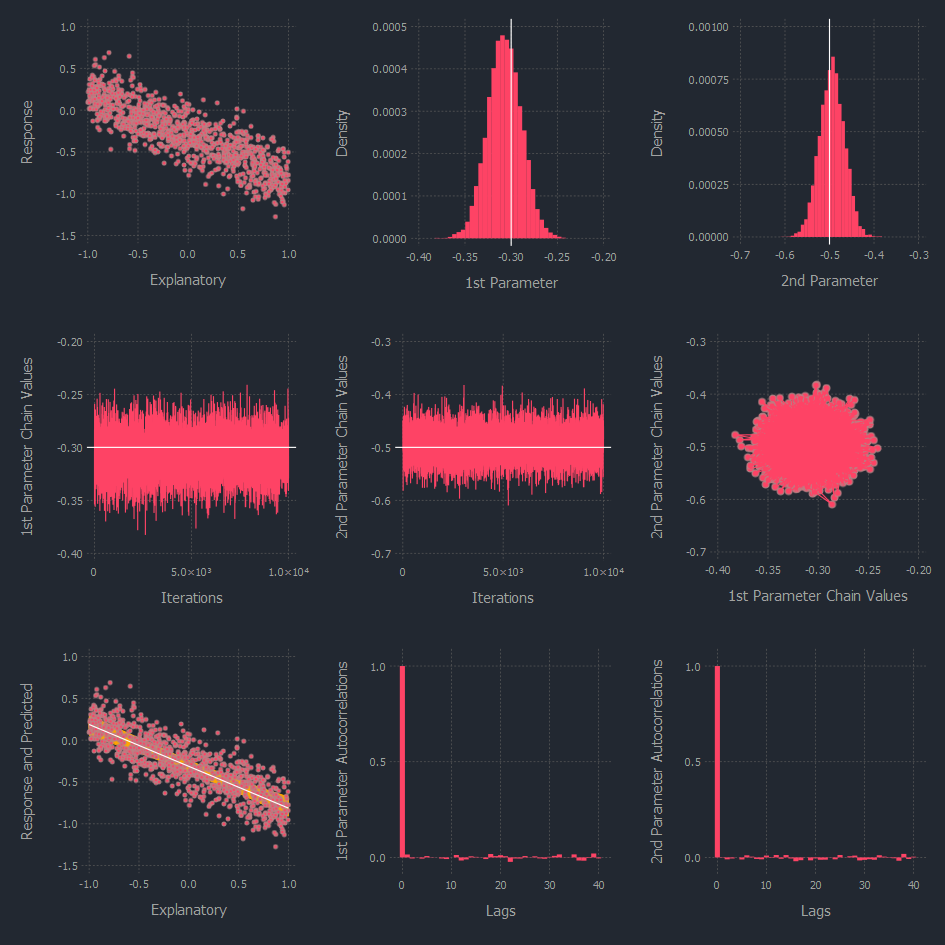

In [163]:
p0 = plot(xy_df, x = :X, y = :Y, Geom.point, style(default_point_size = .05cm), Guide.xlabel("Explanatory"), Guide.ylabel("Response"))
p1 = plot(DataFrame(chain4), x = :x1, xintercept = [-.3], Geom.vline(color = colorant"white"), Geom.histogram(bincount = 30, density = true), Guide.xlabel("1st Parameter"), Guide.ylabel("Density"))
p2 = plot(DataFrame(chain4), x = :x2, xintercept = [-.5], Geom.vline(color = colorant"white"), Geom.histogram(bincount = 30, density = true), Guide.xlabel("2nd Parameter"), Guide.ylabel("Density"))
p3 = plot(DataFrame(chain4), x = collect(1:nrow(DataFrame(chain4))), y = :x1, yintercept = [-.3], Geom.hline(color = colorant"white"), Geom.line, Guide.xlabel("Iterations"), Guide.ylabel("1st Parameter Chain Values"))
p4 = plot(DataFrame(chain4), x = collect(1:nrow(DataFrame(chain4))), y = :x2, yintercept = [-.5], Geom.hline(color = colorant"white"), Geom.line, Guide.xlabel("Iterations"), Guide.ylabel("2nd Parameter Chain Values"))
p5 = plot(DataFrame(chain4), x = :x1, y = :x2, Geom.path, Geom.point, Guide.xlabel("1st Parameter Chain Values"), Guide.ylabel("2nd Parameter Chain Values"))
p6 = plot(layer(xy_df_sghmc, x = :X, y = :Yhat, Geom.line, style(default_color = colorant"white")),
          layer(xy_df_sghmc, x = :X, y = :Y, Geom.point, style(default_point_size = .05cm)),
          layer(xy_stack_sghmc, x = :X, y = :Val, group = :Var, Geom.line, style(default_color = colorant"orange")),
          Guide.xlabel("Explanatory"), Guide.ylabel("Response and Predicted"))
p7 = plot(ch4cor_df, x = :x, y = :y1, Geom.bar, Guide.xlabel("Lags"), Guide.ylabel("1st Parameter Autocorrelations"), Coord.cartesian(xmin = -1, xmax = 41, ymin = -.05, ymax = 1.05))
p8 = plot(ch4cor_df, x = :x, y = :y2, Geom.bar,  Guide.xlabel("Lags"), Guide.ylabel("2nd Parameter Autocorrelations"), Coord.cartesian(xmin = -1, xmax = 41, ymin = -.05, ymax = 1.05))
draw(PNG(25cm, 25cm), vstack(hstack(p0, p1, p2), hstack(p3, p4, p5), hstack(p6, p7, p8)))

In [135]:
writetable(joinpath(out_path, "SGHMC Simulations.csv"), chain4 |> DataFrame)